In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf

seed = 2023
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.experimental.numpy.random.seed(seed)
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
# Set a fixed value for the hash seed
os.environ["PYTHONHASHSEED"] = str(seed)
import dolfin as df
import time
from utils import *
from utils_training import *
import prepare_data
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

sns.set_theme()
sns.set_context("paper")
sns.set(rc={"xtick.bottom": True, "ytick.left": True})
colors = sns.color_palette("mako").as_hex()
my_cmap = sns.color_palette("viridis", as_cmap=True)

Invalid MIT-MAGIC-COOKIE-1 key

In [2]:
save_figs = True
small_data = False
level = 2
data = DataLoader(small_data)
agent = Agent(data, small_data)

if not (os.path.exists(f"./images")) and save_figs:
    os.makedirs(f"./images")

file = open(f"./models/best_model/best_epoch.txt")
for y in file.read().split(" "):
    if y.isdigit():
        best_epoch = int(y)
epochs = [50, 100, 200, 250, 500, 750, 1000, 1500, 2000, best_epoch]
print(len(epochs))
print(epochs)

indices = list(range(0, len(epochs)))
size_per_fig = 4
nb_rows = 2
size_row = int(len(indices) / nb_rows)

max_norm_F : 65.79521
data_size,nb_val,nb_train: 1500 187 1313
data shape: (None, 64, 64, 4)
on val data: residues_interior =  1.4574209e-05
FNO2d model created with hyperparameters : modes:10, width:20, pad_prop:0.05 
10
[50, 100, 200, 250, 500, 750, 1000, 1500, 2000, 1330]


# Minimal error on the validation sample

133
[133]


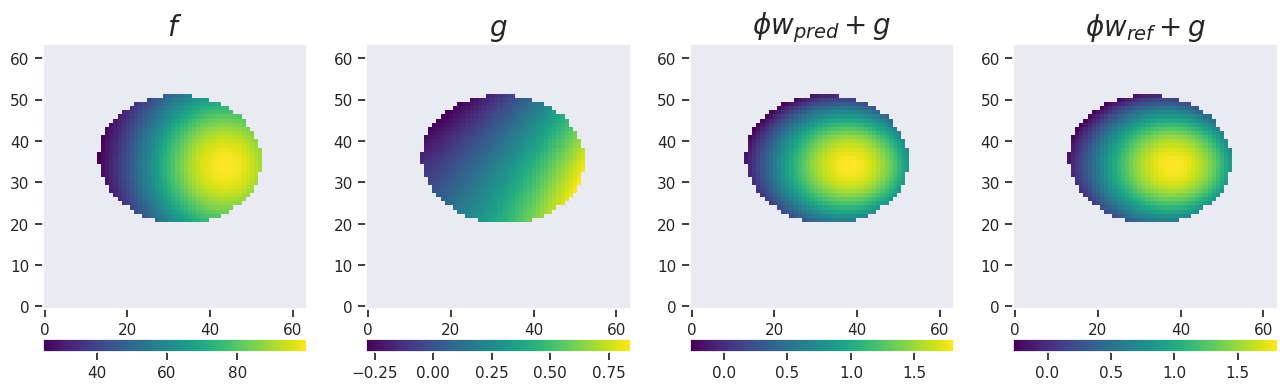

(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.69053334  0.54071942  0.29046935  0.51788049  0.56697524  0.31305477
  0.24631271  3.08295532  0.53796921 -0.1177084 ]
0.000197


In [3]:
i = best_epoch
agent.model.load_weights(f"./models/model_{i}/model_weights")
X_val, Y_val = agent.data.X_val, agent.data.Y_val
Y_pred = agent.model.call(X_val)
domain = X_val[:, :, :, -1]
nb_vert = np.shape(domain)[1]

diff = (
    Y_val * X_val[:, :, :, 1, None]
    + X_val[:, :, :, 2, None]
    - (Y_pred * X_val[:, :, :, 1, None] + X_val[:, :, :, 2, None])
)

L2_error = tf.sqrt(
    tf.reduce_mean(
        (diff**2) * X_val[:, :, :, -1, None],
        axis=[1, 2, 3],
    )
    / tf.reduce_mean(
        ((Y_val * X_val[:, :, :, 1, None] + X_val[:, :, :, 2, None]) ** 2)
        * X_val[:, :, :, -1, None],
        axis=[1, 2, 3],
    )
)

argmin = np.argmin(L2_error)
print(argmin)
sorted_min = sorted(range(len(L2_error)), key=lambda k: L2_error[k])
minimal_errors = sorted_min[:1]
print(minimal_errors)

Params = np.load(f"../data/agentParams.npy")
data_size = np.shape(Params)[0]
nb_val = np.shape(data.X_val)[0]
nb_train = data_size - nb_val
params_val = Params[nb_train:]

for i in minimal_errors:
    X = data.X_val[i, :, :]
    F = X[:, :, 0] * data.max_norm_F
    W_ref = data.Y_val[i]
    Y = agent.model.call(X[None, :, :, :])
    domains_nan = X[:, :, -1].numpy()
    domains_nan[domains_nan == 0] = np.nan

    plt.figure(figsize=(16, 4))

    ax1 = plt.subplot(141)
    img = ax1.imshow(
        F * domains_nan, cmap=my_cmap, aspect="equal", origin="lower"
    )
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("bottom", size="5%", pad=0.3)
    ax1.grid(False)
    ax1.set_title(r"$f$", fontsize=20)
    plt.colorbar(img, cax=cax, orientation="horizontal")

    ax2 = plt.subplot(142)
    img = ax2.imshow(
        (X[:, :, 2]) * domains_nan,
        cmap=my_cmap,
        aspect="equal",
        origin="lower",
    )
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("bottom", size="5%", pad=0.3)
    ax2.grid(False)
    ax2.set_title(r"$g$", fontsize=20)
    plt.colorbar(img, cax=cax, orientation="horizontal")

    ax3 = plt.subplot(143)
    img = ax3.imshow(
        (Y[0, :, :, 0] * X[:, :, 1] + X[:, :, 2]) * domains_nan,
        cmap=my_cmap,
        aspect="equal",
        origin="lower",
    )
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("bottom", size="5%", pad=0.3)
    ax3.grid(False)
    ax3.set_title(r"$\phi w_{pred} + g$", fontsize=20)
    plt.colorbar(img, cax=cax, orientation="horizontal")

    ax4 = plt.subplot(144)
    img = ax4.imshow(
        (W_ref[:, :, 0] * X[:, :, 1] + X[:, :, 2]) * domains_nan,
        cmap=my_cmap,
        aspect="equal",
        origin="lower",
    )
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes("bottom", size="5%", pad=0.3)
    ax4.grid(False)
    ax4.set_title(r"$\phi w_{ref} + g$", fontsize=20)
    plt.colorbar(img, cax=cax, orientation="horizontal")

    if save_figs:
        plt.savefig(f"./images/best_prediction_{L2_error[i]:6f}.png")
    plt.show()

    params = params_val[i]
    print(
        f"(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = {params}"
    )
    print(f"{L2_error[i]:6f}")

# Relative errors with respect to a $\phi$-FEM solution

## On the validation set

We then compute the errors (using the same norm and the $L^\infty$ norm) for the different models, to analyze the convergence of the method on the validation sample.

In [4]:
L2_errors = []
Linf_errors = []

for i in epochs:
    agent.model.load_weights(f"./models/model_{i}/model_weights")
    X_val, Y_val = agent.data.X_val, agent.data.Y_val
    Y_pred = agent.model.call(X_val)
    domain = X_val[:, :, :, -1]
    nb_vert = np.shape(domain)[1]

    diff = (
        Y_val * X_val[:, :, :, 1, None]
        + X_val[:, :, :, 2, None]
        - (Y_pred * X_val[:, :, :, 1, None] + X_val[:, :, :, 2, None])
    )

    val = tf.sqrt(
        tf.reduce_mean(
            (diff**2) * X_val[:, :, :, -1, None],
            axis=[1, 2, 3],
        )
        / tf.reduce_mean(
            ((Y_val * X_val[:, :, :, 1, None] + X_val[:, :, :, 2, None]) ** 2)
            * X_val[:, :, :, -1, None],
            axis=[1, 2, 3],
        )
    )

    L2_errors.append(val)
    Linf_errors.append(
        np.max(
            np.max(np.absolute(diff * X_val[:, :, :, -1, None]), axis=1),
            axis=1,
        )
        / np.max(
            np.max(
                np.absolute(
                    (Y_val * X_val[:, :, :, 1, None] + X_val[:, :, :, 2, None])
                    * X_val[:, :, :, -1, None]
                ),
                axis=1,
            ),
            axis=1,
        )
    )

L2_errors = np.array(L2_errors)
Linf_errors = np.array(Linf_errors)
Linf_errors = np.reshape(Linf_errors, (np.shape(L2_errors)))


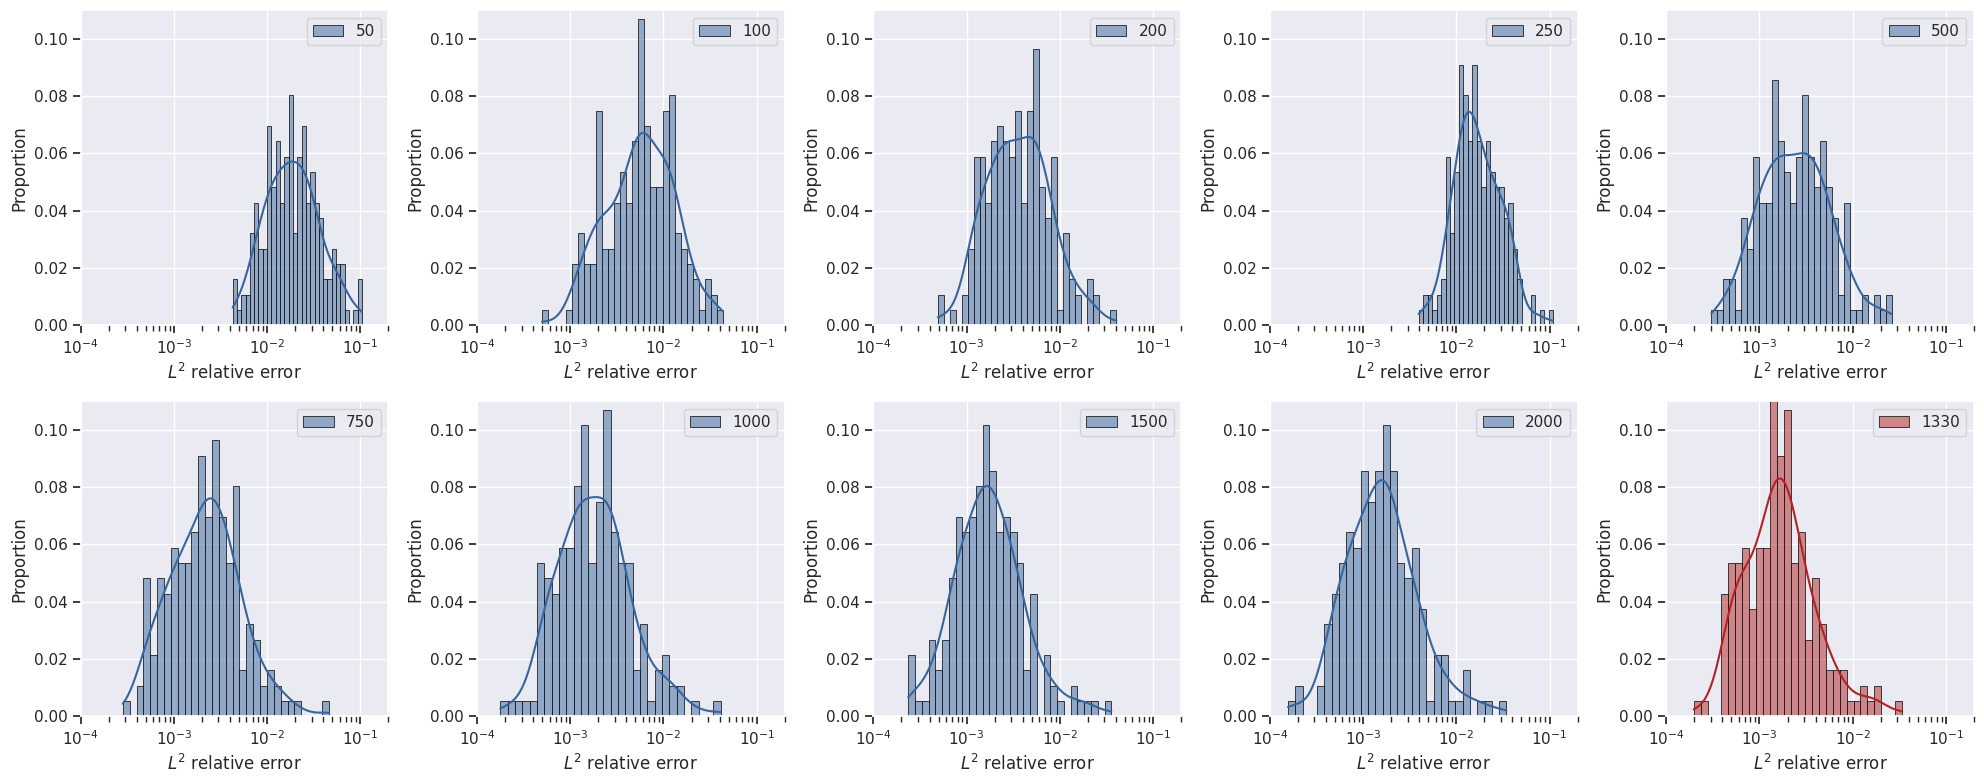

In [5]:
j, k = 0, 0
fig, axes = plt.subplots(
    nb_rows,
    size_row,
    figsize=(size_per_fig * size_row, size_per_fig * nb_rows),
)

for i in range(len(indices)):
    if k == size_row:
        k = 0
        j += 1

    if epochs[indices[i]] == best_epoch:
        color = "firebrick"
    else:
        color = colors[2]
    sns.histplot(
        data=L2_errors[indices[i]],
        kde=True,
        bins=30,
        color=color,
        edgecolor="k",
        log_scale=True,
        label=str(epochs[indices[i]]),
        stat="proportion",
        legend=True,
        ax=axes[j, k],
    )
    axes[j, k].set_xlabel("$L^2$ relative error")
    axes[j, k].legend()
    axes[j, k].set_xlim(1e-4, 2e-1)
    axes[j, k].set_ylim(0.0, 0.11)
    k += 1

plt.tight_layout()
if save_figs:
    plt.savefig(f"./images/histograms_validation_L2.png")
plt.show()

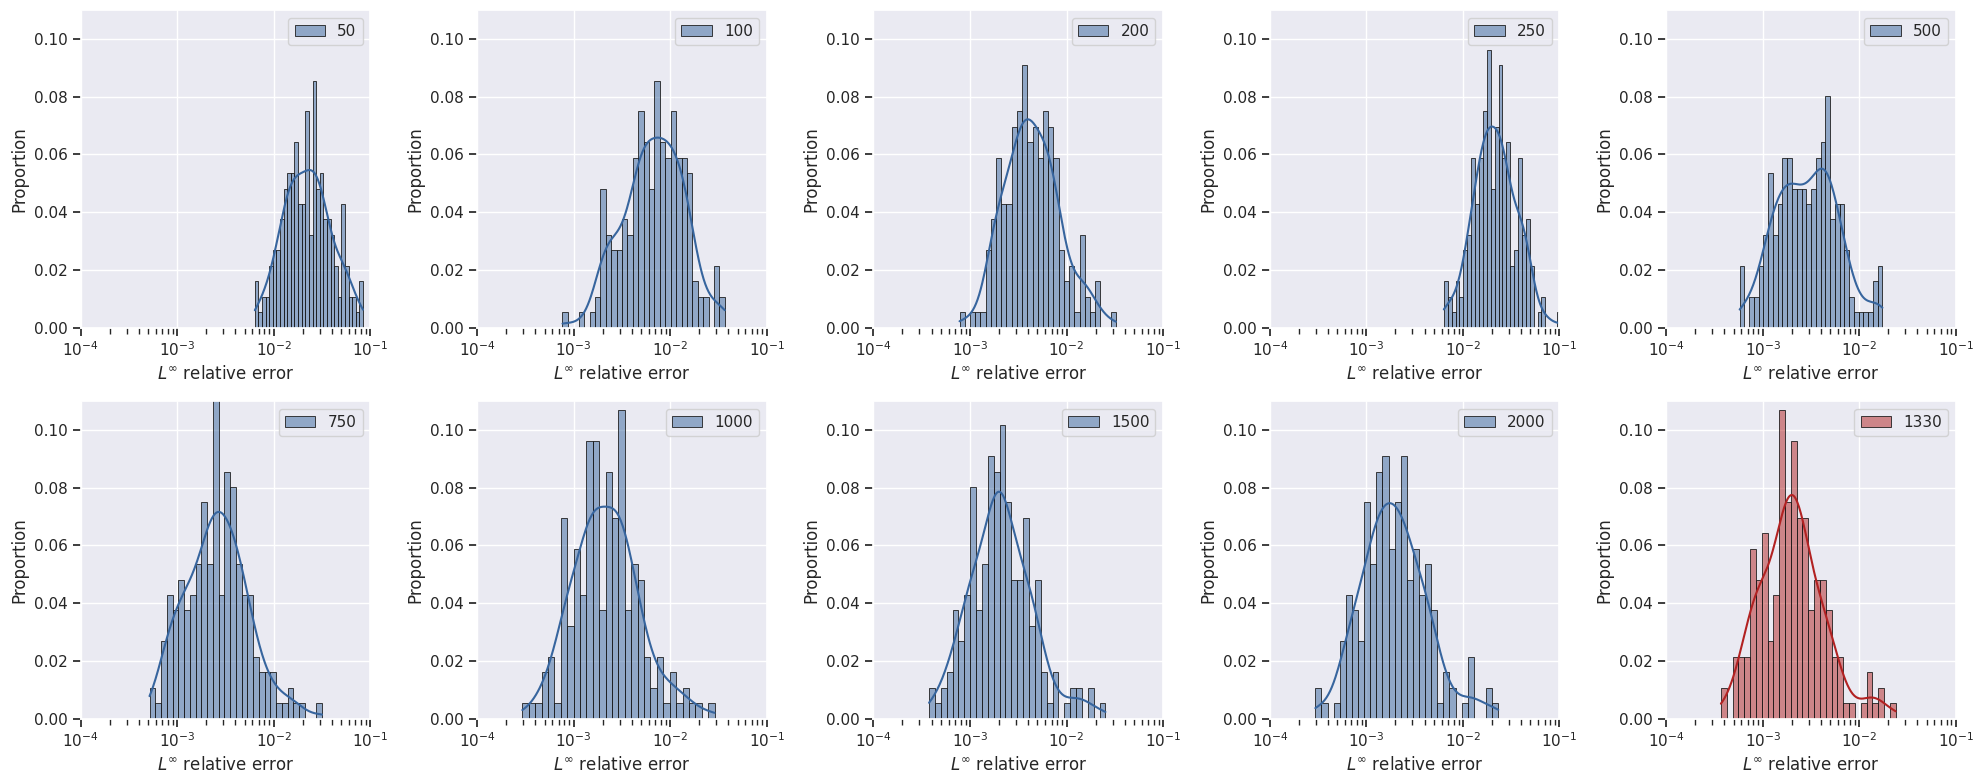

In [6]:
j, k = 0, 0
fig, axes = plt.subplots(
    nb_rows,
    size_row,
    figsize=(size_per_fig * size_row, size_per_fig * nb_rows),
)

for i in range(len(indices)):
    if k == size_row:
        k = 0
        j += 1

    if epochs[indices[i]] == best_epoch:
        color = "firebrick"
    else:
        color = colors[2]
    sns.histplot(
        data=Linf_errors[indices[i]],
        kde=True,
        bins=30,
        color=color,
        edgecolor="k",
        log_scale=True,
        label=str(epochs[indices[i]]),
        stat="proportion",
        legend=True,
        ax=axes[j, k],
    )
    axes[j, k].set_xlabel("$L^\infty$ relative error")
    axes[j, k].legend()
    axes[j, k].set_xlim(1e-4, 1e-1)
    axes[j, k].set_ylim(0.0, 0.11)
    k += 1

plt.tight_layout()
if save_figs:
    plt.savefig(f"./images/histograms_validation_Linf.png")
plt.show()

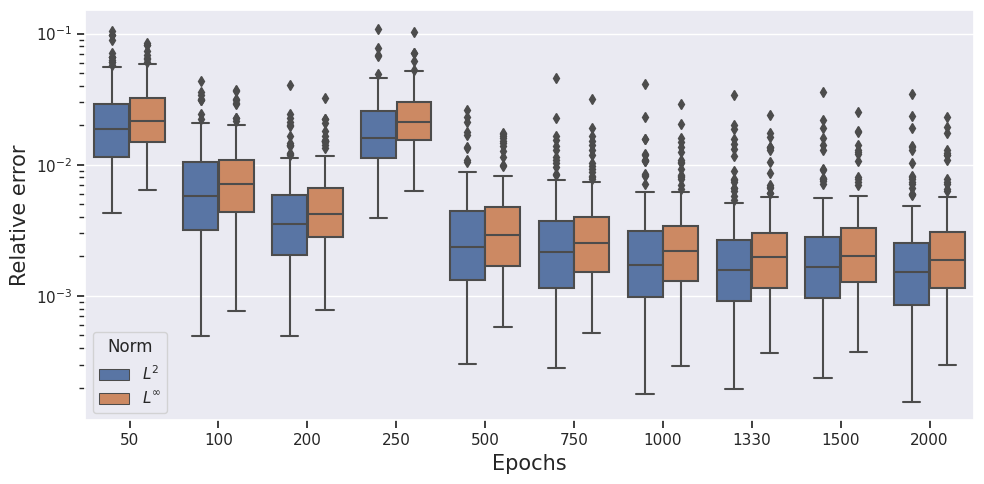

In [7]:
plt.figure(figsize=(10, 5))

size_val = len(L2_errors[0])

epoch_repeat = np.array([])
for epoch in epochs:
    tab = np.repeat(str(epoch), size_val)
    epoch_repeat = np.concatenate([epoch_repeat, tab], axis=0)

tab_L2 = np.repeat(["$L^2$"], size_val * len(epochs))

errors_L2_flatten = np.array(L2_errors).flatten()

df_array_L2 = np.stack([epoch_repeat, errors_L2_flatten, tab_L2], axis=0)

tab_Linf = np.repeat(["$L^\infty$"], size_val * len(epochs))
errors_Linf_flatten = np.array(Linf_errors).flatten()
df_array_Linf = np.stack([epoch_repeat, errors_Linf_flatten, tab_Linf], axis=0)

df_array = np.concatenate([df_array_L2, df_array_Linf], axis=1)

name = ["Epochs", "Error", "Norm"]
df_errors = pd.DataFrame(df_array.transpose(), columns=name)
df_errors = df_errors.astype(
    {"Epochs": "int", "Error": "float64", "Norm": "category"}
)

sns.boxplot(
    data=df_errors,
    x="Epochs",
    y="Error",
    hue="Norm",
    dodge=True,
)
plt.yscale("log")
plt.ylabel("Relative error", fontsize=15)
plt.xlabel("Epochs", fontsize=15)
plt.tight_layout()

if save_figs:
    plt.savefig(f"./images/boxplots_validation_L2_Linf.png")
plt.show()

(10, 187)


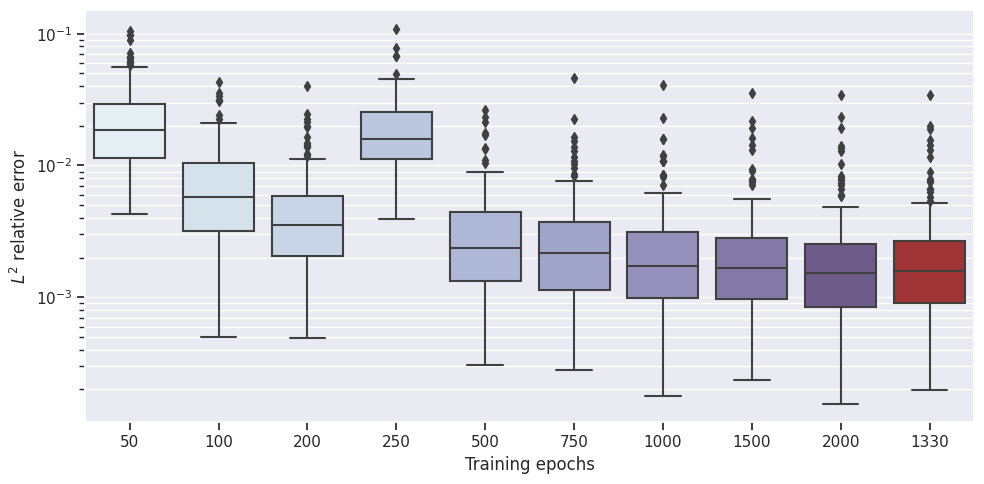

In [8]:
palette = sns.cubehelix_palette(
    n_colors=len(epochs) - 1, start=0.25, rot=-0.25, gamma=0.5
)
palette = palette.as_hex()
palette.append("#b22222")
palette = sns.color_palette(palette)

plt.figure(figsize=(10, 5))
errors = np.array(L2_errors[:])
print(np.shape(errors))
dataframe = pd.DataFrame(errors.transpose(), columns=epochs)

sns.boxplot(data=dataframe, palette=palette)
plt.xlabel("Training epochs")
plt.ylabel("$L^2$ relative error")
plt.yscale("log")
plt.grid(True, "both", "y")
plt.tight_layout()
if save_figs:
    plt.savefig(f"./images/boxplots_validation_epochs_L2_error.png")
plt.show()

In [9]:
epochs_means = list(i * 40 for i in range(1, 51))
epochs_means.append(best_epoch)

print(len(epochs_means))
print(epochs_means)

L2_errors = []
Linf_errors = []

for i in epochs_means:
    agent.model.load_weights(f"./models/model_{i}/model_weights")
    X_val, Y_val = agent.data.X_val, agent.data.Y_val
    Y_pred = agent.model.call(X_val)
    domain = X_val[:, :, :, -1]
    nb_vert = np.shape(domain)[1]

    diff = (
        Y_val * X_val[:, :, :, 1, None]
        + X_val[:, :, :, 2, None]
        - (Y_pred * X_val[:, :, :, 1, None] + X_val[:, :, :, 2, None])
    )

    val = tf.sqrt(
        tf.reduce_mean(
            (diff**2) * X_val[:, :, :, -1, None],
            axis=[1, 2, 3],
        )
        / tf.reduce_mean(
            ((Y_val * X_val[:, :, :, 1, None] + X_val[:, :, :, 2, None]) ** 2)
            * X_val[:, :, :, -1, None],
            axis=[1, 2, 3],
        )
    )

    L2_errors.append(val)
    Linf_errors.append(
        np.max(
            np.max(np.absolute(diff * X_val[:, :, :, -1, None]), axis=1),
            axis=1,
        )
        / np.max(
            np.max(
                np.absolute(
                    (Y_val * X_val[:, :, :, 1, None] + X_val[:, :, :, 2, None])
                    * X_val[:, :, :, -1, None]
                ),
                axis=1,
            ),
            axis=1,
        )
    )

51
[40, 80, 120, 160, 200, 240, 280, 320, 360, 400, 440, 480, 520, 560, 600, 640, 680, 720, 760, 800, 840, 880, 920, 960, 1000, 1040, 1080, 1120, 1160, 1200, 1240, 1280, 1320, 1360, 1400, 1440, 1480, 1520, 1560, 1600, 1640, 1680, 1720, 1760, 1800, 1840, 1880, 1920, 1960, 2000, 1330]


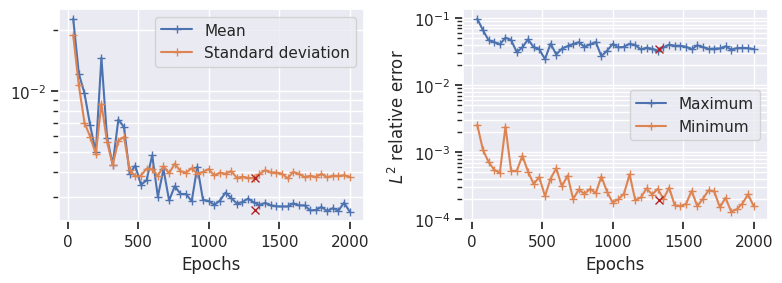

In [10]:
means = np.mean(L2_errors, axis=1)
standard_deviation = np.std(L2_errors, axis=1)
maxs = np.max(L2_errors, axis=1)
mins = np.min(L2_errors, axis=1)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.semilogy(epochs_means[:-1], means[:-1], "-+", label="Mean")
plt.semilogy(
    epochs_means[:-1],
    standard_deviation[:-1],
    "-+",
    label="Standard deviation",
)
plt.semilogy(epochs_means[-1], means[-1], "x", c="firebrick", markersize=6)
plt.semilogy(
    epochs_means[-1], standard_deviation[-1], "x", c="firebrick", markersize=6
)
plt.xlabel("Epochs")
plt.grid(True, "both", "both")
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(epochs_means[:-1], maxs[:-1], "-+", label="Maximum")
plt.semilogy(epochs_means[:-1], mins[:-1], "-+", label="Minimum")
plt.semilogy(epochs_means[-1], maxs[-1], "x", c="firebrick", markersize=6)
plt.semilogy(epochs_means[-1], mins[-1], "x", c="firebrick", markersize=6)
plt.grid(True, "both", "both")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("$L^2$ relative error")
plt.tight_layout()

if save_figs:
    plt.savefig(f"./images/min_mean_max_L2_error_epochs.png")
plt.show()

## On a new test dataset

We now move to the case of new data. We generate a new dataset and compute the error between a $\phi$-FEM solution of the dataset and a prediction of the trained model. 

In [11]:
from generate_data import PhiFemSolver
from prepare_data import set_seed

set_seed(2025)


In [12]:
F, Phi, G, params = create_FG_numpy(300, 64)
solver = PhiFemSolver(nb_cell=64 - 1, params=params)
W_phi_fem = solver.solve_several()
print(f"{np.shape(W_phi_fem)=}")

L2_errors_fno = []

for j in epochs:
    print(f"Epoch : {j}")
    agent.model.load_weights(f"./models/model_{j}/model_weights")
    L2_error_fno = []
    X = generate_manual_new_data_numpy(Phi, F / data.max_norm_F, G)
    Y_pred = agent.model.call(X)

    domain = X[:, :, :, -1]
    nb_vert = np.shape(domain)[1]
    diff = (
        W_phi_fem[:, :, :] * X[:, :, :, 1]
        + G
        - (Y_pred[:, :, :, 0] * X[:, :, :, 1] + G)
    )

    L2_error_fno = tf.sqrt(
        tf.reduce_mean(
            (diff**2) * X[:, :, :, -1],
            axis=[1, 2],
        )
        / tf.reduce_mean(
            ((W_phi_fem * X[:, :, :, 1] + G) ** 2)
            * X[:, :, :, -1],
            axis=[1, 2],
        )
    )

    L2_errors_fno.append(L2_error_fno)

(300, 1)
0/300:num of cell in the ghost penalty: 272
Solving linear variational problem.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 4741 nodes for 2371 points.
1/300:num of cell in the ghost penalty: 190
Solving linear variational problem.
Building point search tree to accelerate distance queries.
2/300:Computed bounding box tree with 2595 nodes for 1298 points.
num of cell in the ghost penalty: 220
Solving linear variational problem.
3/300:Building point search tree to accelerate distance queries.
Computed bounding box tree with 3509 nodes for 1755 points.
num of cell in the ghost penalty: 214
Solving linear variational problem.
4/300:Building point search tree to accelerate distance queries.
Computed bounding box tree with 3535 nodes for 1768 points.
num of cell in the ghost penalty: 352
Solving linear variational problem.
Building point search tree to accelerate distance queries.
5/300:Computed bounding box tree with 7977 nodes for 398

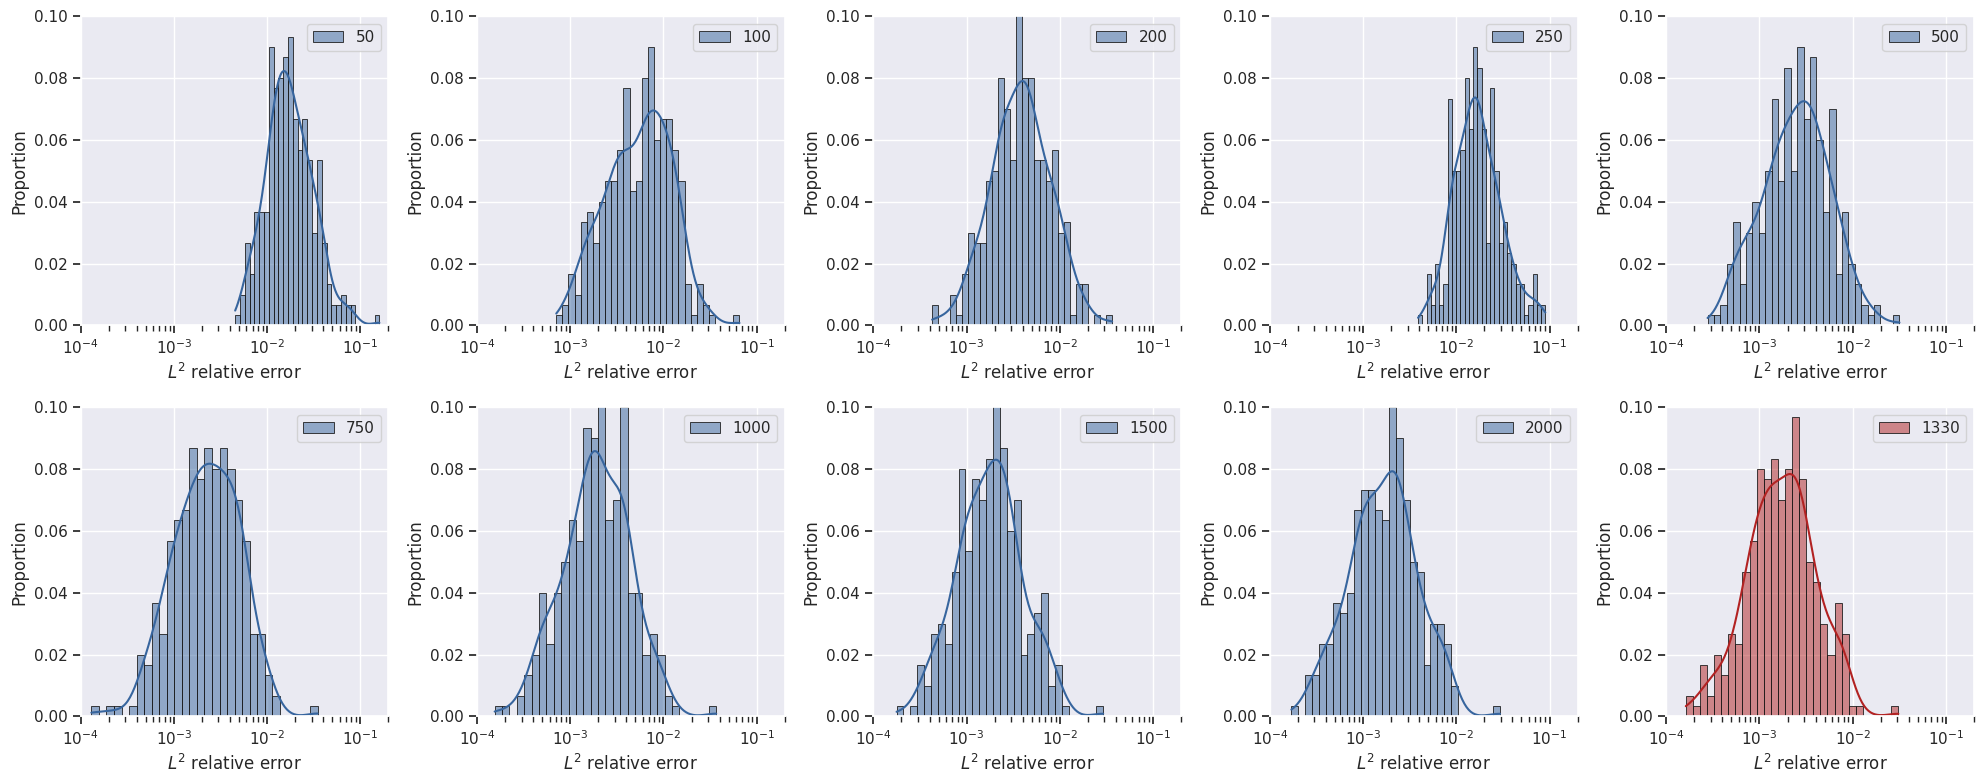

In [13]:
j, k = 0, 0
fig, axes = plt.subplots(
    nb_rows,
    size_row,
    figsize=(size_per_fig * size_row, size_per_fig * nb_rows),
)

for i in range(len(indices)):
    if k == size_row:
        k = 0
        j += 1
    if epochs[indices[i]] == best_epoch:
        color = "firebrick"
    else:
        color = colors[2]
    sns.histplot(
        data=L2_errors_fno[indices[i]],
        kde=True,
        bins=30,
        color=color,
        edgecolor="k",
        log_scale=True,
        label=str(epochs[indices[i]]),
        stat="proportion",
        legend=True,
        ax=axes[j, k],
    )
    axes[j, k].set_xlabel("$L^2$ relative error")
    axes[j, k].legend()
    axes[j, k].set_xlim(1e-4, 2e-1)
    axes[j, k].set_ylim(0.0, 0.10)
    k += 1

plt.tight_layout()
if save_figs:
    plt.savefig(f"./images/histograms_new_data_L2.png")
plt.show()

(10, 300)


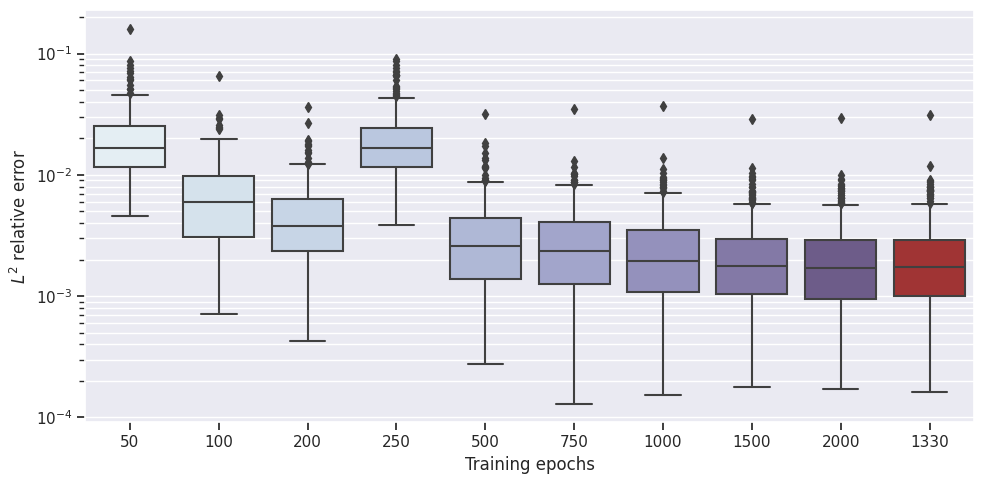

In [14]:
palette = sns.cubehelix_palette(
    n_colors=len(epochs) - 1, start=0.25, rot=-0.25, gamma=0.5
)
palette = palette.as_hex()
palette.append("#b22222")
palette = sns.color_palette(palette)

plt.figure(figsize=(10, 5))
errors_fno = np.array(L2_errors_fno[:])
print(np.shape(errors_fno))
dataframe = pd.DataFrame(errors_fno.transpose(), columns=epochs)

sns.boxplot(data=dataframe, palette=palette)
plt.xlabel("Training epochs")
plt.ylabel("$L^2$ relative error")
plt.yscale("log")
plt.grid(True, "both", "y")
plt.tight_layout()
if save_figs:
    plt.savefig(f"./images/boxplots_new_data_L2.png")
plt.show()

In [15]:
L2_errors_fno = []

for j in epochs_means:
    print(f"Epoch : {j}")
    agent.model.load_weights(f"./models/model_{j}/model_weights")
    L2_error_fno = []
    X = generate_manual_new_data_numpy(Phi, F / data.max_norm_F, G)
    Y_pred = agent.model.call(X)

    domain = X[:, :, :, -1]
    nb_vert = np.shape(domain)[1]
    diff = (
        W_phi_fem[:, :, :] * X[:, :, :, 1]
        + G
        - (Y_pred[:, :, :, 0] * X[:, :, :, 1] + G)
    )

    L2_error_fno = tf.sqrt(
        tf.reduce_mean(
            (diff**2) * X[:, :, :, -1],
            axis=[1, 2],
        )
        / tf.reduce_mean(
            ((W_phi_fem * X[:, :, :, 1] + G) ** 2)
            * X[:, :, :, -1],
            axis=[1, 2],
        )
    )

    L2_errors_fno.append(L2_error_fno)

Epoch : 40
Epoch : 80
Epoch : 120
Epoch : 160
Epoch : 200
Epoch : 240
Epoch : 280
Epoch : 320
Epoch : 360
Epoch : 400
Epoch : 440
Epoch : 480
Epoch : 520
Epoch : 560
Epoch : 600
Epoch : 640
Epoch : 680
Epoch : 720
Epoch : 760
Epoch : 800
Epoch : 840
Epoch : 880
Epoch : 920
Epoch : 960
Epoch : 1000
Epoch : 1040
Epoch : 1080
Epoch : 1120
Epoch : 1160
Epoch : 1200
Epoch : 1240
Epoch : 1280
Epoch : 1320
Epoch : 1360
Epoch : 1400
Epoch : 1440
Epoch : 1480
Epoch : 1520
Epoch : 1560
Epoch : 1600
Epoch : 1640
Epoch : 1680
Epoch : 1720
Epoch : 1760
Epoch : 1800
Epoch : 1840
Epoch : 1880
Epoch : 1920
Epoch : 1960
Epoch : 2000
Epoch : 1330


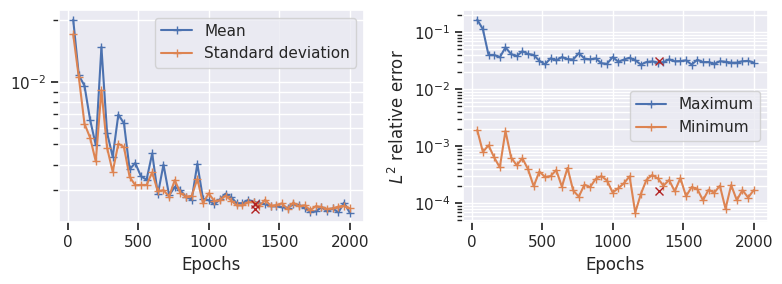

In [16]:
means = np.mean(L2_errors_fno, axis=1)
standard_deviation = np.std(L2_errors_fno, axis=1)
maxs = np.max(L2_errors_fno, axis=1)
mins = np.min(L2_errors_fno, axis=1)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.semilogy(epochs_means[:-1], means[:-1], "-+", label="Mean")
plt.semilogy(
    epochs_means[:-1],
    standard_deviation[:-1],
    "-+",
    label="Standard deviation",
)
plt.semilogy(epochs_means[-1], means[-1], "x", c="firebrick", markersize=6)
plt.semilogy(
    epochs_means[-1], standard_deviation[-1], "x", c="firebrick", markersize=6
)
plt.xlabel("Epochs")
plt.grid(True, "both", "both")
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(epochs_means[:-1], maxs[:-1], "-+", label="Maximum")
plt.semilogy(epochs_means[:-1], mins[:-1], "-+", label="Minimum")
plt.semilogy(epochs_means[-1], maxs[-1], "x", c="firebrick", markersize=6)
plt.semilogy(epochs_means[-1], mins[-1], "x", c="firebrick", markersize=6)
plt.grid(True, "both", "both")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("$L^2$ relative error")

plt.tight_layout()

if save_figs:
    plt.savefig(f"./images/min_mean_max_L2_error_epochs_new_data.png")
plt.show()